In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.text_cell_render li, div.text_cell_render p, code{font-size:12pt; line-height:30px;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

<font size="6" color="red"><b>ch4. 머신러닝 모형 최적화</b></font>
# 1절. 변수 선택과 차원 축소
## 1-1 변수선택과 차원축소
- 종속변수에 영향을 주는 변수들을 찾아 학습에 사용할 독립변수의 수를 줄임
 (어떻게 하면 score를 높일 수 있을지?)
- 과적합과 변수들 사이의 다중공선성(변수들간 강한 상관관계)을 줄일 수 있음
 * 회귀계수 해석이 어려워짐. 모델 예측력이 좋아도 해석력이 떨어짐(어떤 변수가 제일 큰 요인인지 잘), p값이
나 유의성 검정이 왜곡될 수 있음
- 모형의 학습 시간을 줄일 수 있음
- 주성분분석, 상관분석, **분류모형의 feature_importance_, 예측 모형의 coef_**
- SelectKBest : 가장 높은 score에 따라 K개의 특징을 선택
## 1-2 주성분분석(PCA, Principal Component Anaysis)
- 주성분분석은 변수 선택 및 차원축소 방법(기존의 모든 변수를 조합하여 새로운 변수로 만듦) 으로 널리 사용
- 주성분 분석은 상관관계가 있는 변수들을 선형결합해서 **분산이 극대화된 상관관계가 없는 새로운 변수(주성분)
들로 축약**하는 것
- 주성분 분석은 사실 선형대수학이라기보다는 선형대수학의 활용적인 측면이 강하며 영상인식, 통계 데이터분석
(주성분 찾기), 데이터 압축, 노이즈제거 등 여러 분야에 사용
- 영상처리에서 많이 활용 : 여러개의 영상 중 대표 이미지를 찾을 때 활용

In [2]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris_X, iris_y = iris.iloc[:, :-1], iris.species
iris_X.shape, iris_y.shape

((150, 4), (150,))

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # n_components : 주성분 갯수
# pca.fit(iris_X)
# pca.transform(iris_X)
iris_pca = pca.fit_transform(iris_X)
iris_pca[:3] # 뽑혀진 주성분 2개

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943]])

In [4]:
import pandas as pd
pd.DataFrame(iris_pca, columns=['pca1', 'pca2']).corr() # 주성분끼리의 상관관계

,pca1,pca2
pca1,1.000000e+00,3.722081e-16
pca2,3.722081e-16,1.000000e+00


In [5]:
# 설명분산 : 각 주성분이 데이터 분산을 잘 표현하는지 (정보량). 값이 클수록 더 중요한 주성분
pca.explained_variance_

array([4.22824171, 0.24267075])

In [6]:
# 설명정도 : 0~1사이의 비율로 조정된 값
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

In [7]:
pca.components_
# 각 주성분의 계수 : 각 주성분이 원래 특성들과 어떤 관계가 있는지 나타내는 가중치
# pca1 = 0.36138659*s_length + -0.08452251*s_width + 0.85667061*p_length +0.3582892*p_width
# pca2 = 0.65658877*s_length + ~

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

## 1-3 상관관계 확인
- 각 변수들끼리 상관관계를 확인하고 시각화해서 종속변수와 상관관계가 높은 변수들만 선택

In [8]:
import pandas as pd
# redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine = pd.read_csv('data/winequality-red.csv', delimiter=';')
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


- cmap의 종류 : https://jrc-park.tistory.com/155 
- http://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap 
- http://seaborn.pydata.org/examples/many_pairwise_correlations.html 


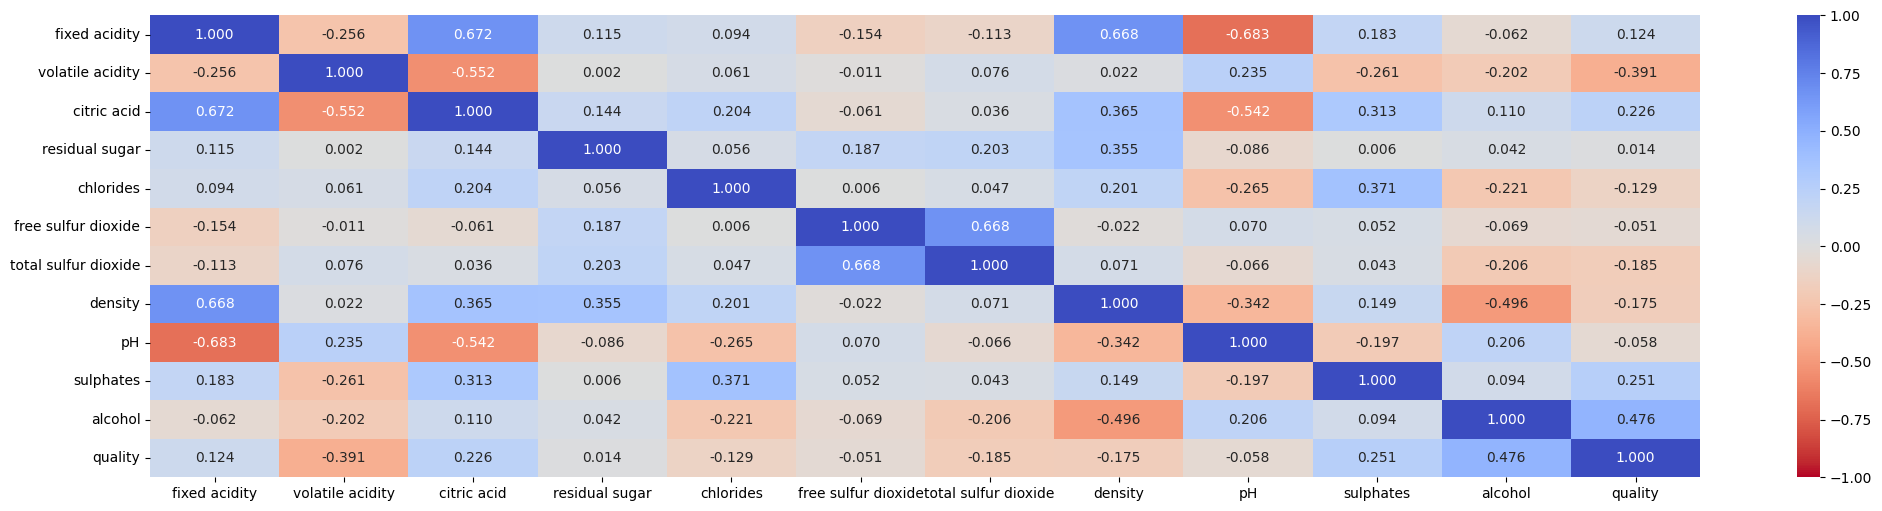

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,6))
corr = redwine.corr()
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm_r')
plt.show()

In [10]:
import numpy as np
mask = np.tril(np.ones_like(corr)) # 대각선 포함하여 아래가 1
mask = np.tril(np.ones_like(corr), k=-1) # 대각선 제외하고 아래가 1
mask = np.triu(np.ones_like(corr)) # 대각선 포함하여 위가 1
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

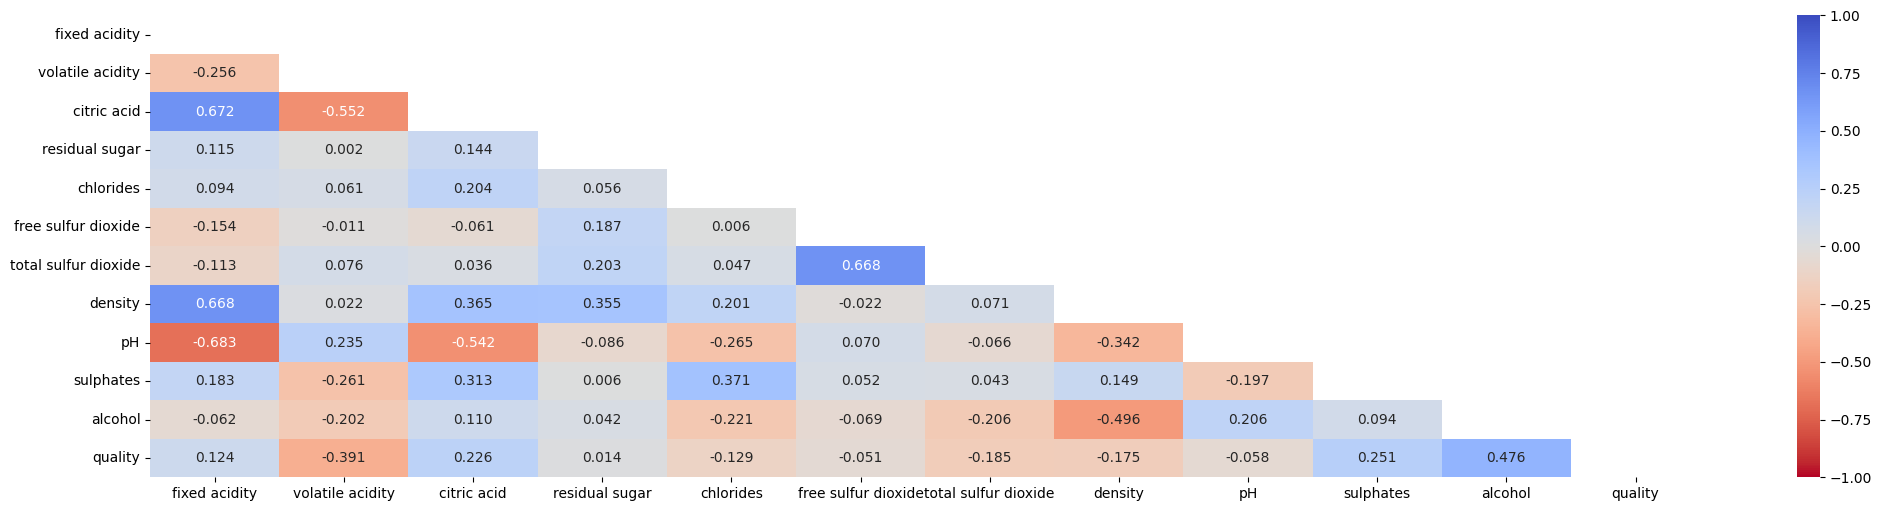

In [11]:
plt.figure(figsize=(25,6))
corr = redwine.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm_r', mask=mask)
plt.show()

## 1-4 분류모형의 Feature Importance
- 분류모형의 feature_importances_ 속성 : 각 독립변수들이 종속변수에 영향을 주는 정도
- DecisionTreeClassifier, RandomForestClassifer, GradientBoostingClassifier..(tree계열)
- LogisticRegression, SVC, MLPclassifier등은 feature_importance_속성없음

In [12]:
from sklearn.model_selection import train_test_split
X = redwine.iloc[:, :-1]#.values # numpy 배열로
y = redwine.iloc[:, -1]#.to_numpy()
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)
train_X.shape, test_X.shape, train_y.shape, test_y.shape, type(train_X)

((1119, 11), (480, 11), (1119,), (480,), pandas.core.frame.DataFrame)

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10, # 트리의 갯수 10
                                 random_state=10)
rf_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=10, random_state=10)

In [14]:
rf_model.score(test_X, test_y) #accuracy

0.6083333333333333

In [15]:
rf_model.feature_importances_ # 종속변수에 영향을 주는 정도

array([0.07390445, 0.08716559, 0.07951926, 0.07161146, 0.08347182,
       0.06706705, 0.10298916, 0.07987915, 0.07538763, 0.10416108,
       0.17484337])

In [16]:
features = pd.DataFrame(np.c_[X.columns, rf_model.feature_importances_],
                        columns=['feature', 'importance'])
features['importance'].sum()

1.0

In [17]:
features.sort_values(by='importance', ascending=False, inplace=True)
features.reset_index(drop=True, inplace=True)
features.set_index(drop=True, keys='feature') # 열이름을 index로 

,importance
feature,
alcohol,0.174843
sulphates,0.104161
total sulfur dioxide,0.102989
volatile acidity,0.087166
chlorides,0.083472
density,0.079879
citric acid,0.079519
pH,0.075388
fixed acidity,0.073904


### feature_importances_를 이용한 변수 중요도 시각화

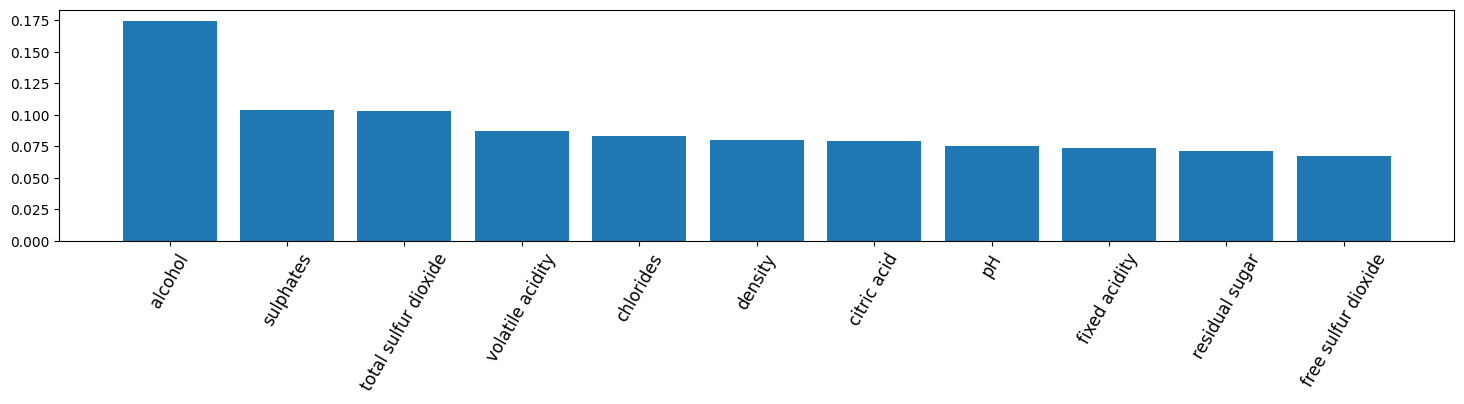

In [18]:
#features를 시각화
plt.figure(figsize=(18,3))
plt.bar(features.feature, features.importance)
plt.xticks(fontsize=12, rotation=60)
plt.show()

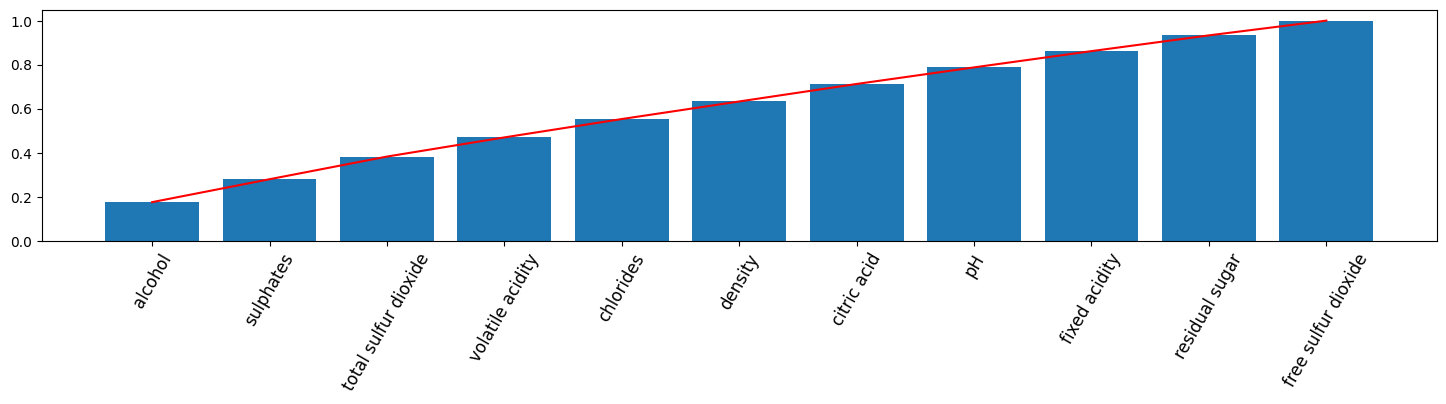

In [19]:
# 누적합을 이용한 시각화
y_stack = np.cumsum(features.importance)
plt.figure(figsize=(18,3))
plt.bar(features.feature, y_stack)
plt.plot(features.feature, y_stack, color='red')
plt.xticks(fontsize=12, rotation=60)
plt.show()

### RFE(Recursive Feature Elimination) 방식
- RFE를 이용하면 중요도에 따라 중요도가 낮은 변수부터 하나씩 제거해 나가면서 최종적으로 선택한 변수를 찾는다

In [20]:
from sklearn.feature_selection import RFE
rfe_model = RFE(#RandomForestClassifier(n_estimators=10, random_state=10)
                rf_model,
                n_features_to_select=5
)
rfe_model.fit(train_X, train_y)
rfe_model.get_support() # 선택된 변수(True)인지 제거된 변수(False)인지 여부

array([False, False, False, False,  True, False,  True,  True, False,
        True,  True])

In [21]:
feature_rfe = pd.DataFrame(np.c_[X.columns, rfe_model.get_support()],
                          columns=['feature', 'selected'])
feature_rfe[feature_rfe.selected==True]

,feature,selected
4,chlorides,True
6,total sulfur dioxide,True
7,density,True
9,sulphates,True
10,alcohol,True


## 1-5 SelectKBest
- 가장 높은 score에 따라 k개 특징변수 선택

In [22]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, f_classif, chi2
# f_classif : ANNOVA F검정 - 독립변수가 연속형(그룹간 차이가 유의미한지)
# chi2      : 카이제곱통계량 검정 - 독립변수가 범주형(타겟변수도 범주형) 또는 양의 실수
X, y = load_iris(return_X_y=True, as_frame=False)
X.shape, y.shape
X_new = SelectKBest(f_classif, k=1).fit_transform(X, y)

In [23]:
load_iris()['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [24]:
X_new[:3] # petal length (cm)

array([[1.4],
       [1.4],
       [1.3]])

In [25]:
X[:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

# 2절. 파라미터 탐색
- 하이퍼파라미터(모델의 성능에 영향을 미칠 수 있는 사용자가 직접 설정하는 파라미터). 
- 어떤 파라미터를 사용하는게 최적의 결과를 낼지 탐색
- sklearn패키지의 하이퍼 파라미터 튜닝 도구
    * validation_curve() : 단일 하이퍼 파라미터 최적화 함수
    * GridSearchCV : 복수 하이퍼파리미터 최적화 클래스
## 2-1 validation_curve
    - 모형, X, y, param_name(파라미터이름), param_range(파라미터값list), 교차검증, scoring 기준

In [74]:
# 데이터
from sklearn.datasets import load_digits
digits = load_digits()
# digits.data.shape 1797 x 64 크기의 배열
# digits.target : 1797 크기의 배열(0~9중 하나)
# digits.images.shape 1797 x 8 x 8 크기의 배열(이미지 형태)
X, y = digits.data, digits.target
X.shape, y.shape

((1797, 64), (1797,))

In [35]:
X[0].reshape(8,8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [40]:
y[0]

0

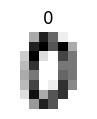

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.imshow(X[0].reshape(8,8), cmap='gray_r')
plt.axis('off')
plt.title(y[0])
plt.show()

In [42]:
from sklearn.svm import SVC
model = SVC(probability=True)
model.fit(X, y) # 기본 파라미터로 모형 생성

SVC(probability=True)

In [46]:
test_x = X[0].reshape(1, -1)
test_x.shape
print('예측 :', model.predict(test_x), ', 실제 :', y[0])

예측 : [0] , 실제 : 0


In [51]:
prob = model.predict_proba(test_x)[0]
classes = model.classes_
print('분류 :', classes)
print('확률 :', prob)
for c, p in zip(classes, prob):
    print('{}일 확률 : {:.5f}%'.format(c, p*100))

분류 : [0 1 2 3 4 5 6 7 8 9]
확률 : [9.91094821e-01 1.82743529e-04 4.69710581e-04 8.40012428e-04
 6.49698185e-04 1.36911696e-03 7.43912553e-04 9.48540420e-04
 6.83127199e-04 3.01831690e-03]
0일 확률 : 99.10948%
1일 확률 : 0.01827%
2일 확률 : 0.04697%
3일 확률 : 0.08400%
4일 확률 : 0.06497%
5일 확률 : 0.13691%
6일 확률 : 0.07439%
7일 확률 : 0.09485%
8일 확률 : 0.06831%
9일 확률 : 0.30183%


In [52]:
# 파라미터 탐색 score (accuracy)
model.score(X, y)

0.996661101836394

In [53]:
# SVC() 모형의 최적의 gamma값 탐색
param_range = np.logspace(-6, -1, 10) # e-06 ~ e-01 10개 : gamma 값의 후보군
param_range

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

In [54]:
%%time
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve(
        SVC(), # 예측모형
        X, y,
        param_name='gamma', # gamma가 크면 결정경계가 복잡 -> overfitting
        param_range=param_range,
        cv=10, # 교차검증 
        scoring='accuracy', # balanced_accuracy(불균형을 고려한 정확도)
        n_jobs=-1 # 모든 코어
)

CPU times: total: 375 ms
Wall time: 9.7 s


In [55]:
train_scores

array([[0.10204082, 0.10204082, 0.10204082, 0.10204082, 0.10204082,
        0.10204082, 0.10204082, 0.28615575, 0.19159456, 0.19159456],
       [0.71923315, 0.70995671, 0.72108844, 0.716141  , 0.71552257,
        0.71243043, 0.70810142, 0.72435105, 0.73918418, 0.73856613],
       [0.93753865, 0.93444651, 0.93320965, 0.93135436, 0.93692022,
        0.92888064, 0.93382808, 0.93201483, 0.94313968, 0.93263288],
       [0.96846011, 0.96969697, 0.96722325, 0.97217069, 0.96846011,
        0.96722325, 0.96846011, 0.96538937, 0.97342398, 0.97342398],
       [0.98824985, 0.98577613, 0.9894867 , 0.98763142, 0.98639456,
        0.98824985, 0.98824985, 0.98702101, 0.98825711, 0.98825711],
       [0.99814471, 0.99690785, 0.99814471, 0.99752628, 0.99690785,
        0.99814471, 0.99814471, 0.99814586, 0.99814586, 0.99876391],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.       

In [56]:
test_scores

array([[0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.29608939, 0.19553073, 0.19553073],
       [0.67777778, 0.74444444, 0.7       , 0.66666667, 0.73333333,
        0.67222222, 0.72222222, 0.70949721, 0.67597765, 0.73743017],
       [0.87777778, 0.95      , 0.90555556, 0.86666667, 0.92222222,
        0.91666667, 0.96666667, 0.93854749, 0.83240223, 0.91061453],
       [0.92222222, 0.96666667, 0.95      , 0.91111111, 0.95      ,
        0.98333333, 0.97777778, 0.96648045, 0.87709497, 0.92178771],
       [0.93888889, 0.97222222, 0.93333333, 0.95      , 0.97222222,
        0.98888889, 0.98333333, 0.99441341, 0.91061453, 0.94413408],
       [0.95555556, 1.        , 0.93333333, 0.96666667, 0.98888889,
        0.98888889, 0.99444444, 0.99441341, 0.96089385, 0.96648045],
       [0.93333333, 0.98888889, 0.95555556, 0.96666667, 0.98333333,
        0.98888889, 0.99444444, 0.99441341, 0.97765363, 0.96648045],
       [0.77777778, 0.89444444, 0.7611111

In [58]:
test_scores.shape, train_scores.shape

((10, 10), (10, 10))

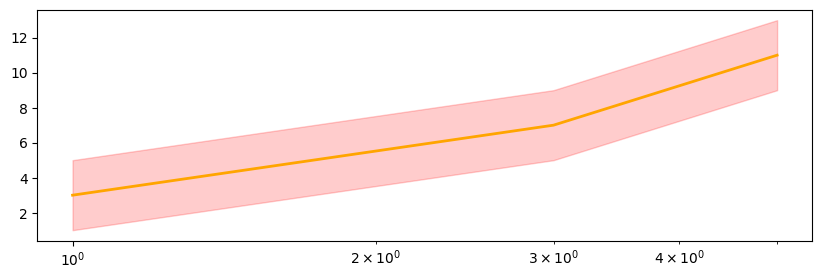

In [73]:
a = np.array([1,3,5])
b = np.array([3,7,11])
plt.figure(figsize=(10,3))
plt.semilogx(a, b, color='orange', lw=2)
plt.fill_between(a, b-2, b+2, color='red', alpha=0.2)
plt.show()

In [61]:
train_scores_mean = np.mean(train_scores, axis=1) # train 평균
train_scores_std = np.std(train_scores, axis=1) # train 표준편차
test_scores_mean = np.mean(test_scores, axis=1) # test 평균
test_scores_std = np.std(test_scores, axis=1) # test 표준편차

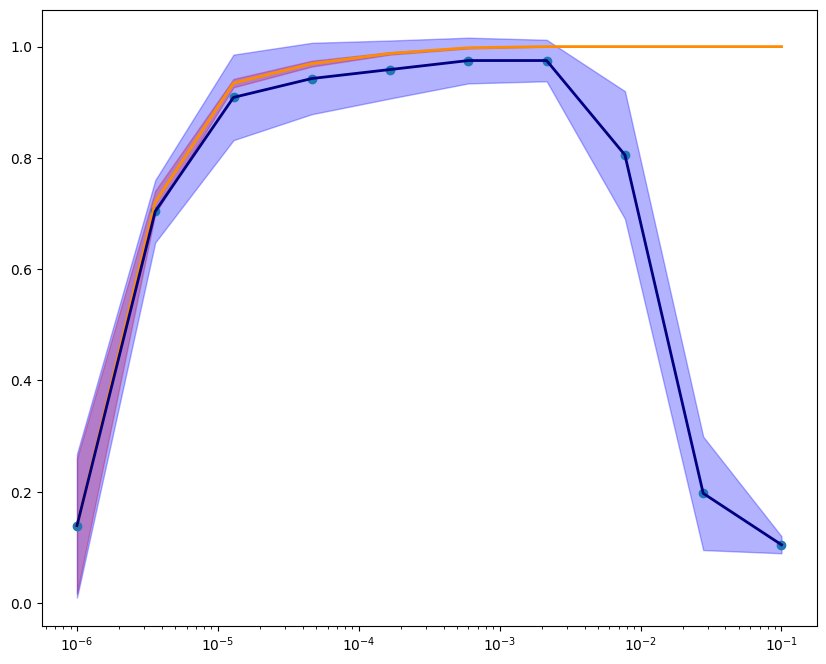

In [69]:
plt.figure(figsize=(10,8))
plt.semilogx(param_range, train_scores_mean, color='darkorange', lw=2)
plt.fill_between(param_range, train_scores_mean-train_scores_std*2,
                train_scores_mean+train_scores_std*2,
                alpha=0.3, color='red')

plt.semilogx(param_range, test_scores_mean, color='navy', lw=2)
plt.fill_between(param_range, test_scores_mean-test_scores_std*2,
                test_scores_mean+test_scores_std*2,
                alpha=0.3, color='blue')
plt.scatter(param_range, test_scores_mean)
plt.show()

In [70]:
test_scores_mean.argmax()

6

In [72]:
# 최적의 gamma
gamma_best = param_range[test_scores_mean.argmax()]
gamma_best

0.0021544346900318843

In [75]:
model = SVC(gamma=gamma_best).fit(X, y)

In [76]:
model.score(X, y)

1.0

## 2-2 GridSearchCV
- 복수의 하이퍼파라미터 최적화 클래스
- 모형 클래스를 가지고 있음
- fit() / predict() / score() / predict_proba() / predict_log_proba()

In [77]:
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine_X = redwine.iloc[:,:-1]
redwine_y = redwine.iloc[:, -1]
redwine_X.shape, redwine_y.shape

((1599, 11), (1599,))

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC

In [82]:
%%time
# 가장 평가 점수가 높은 독립변수 ?개 선택, SVC() 모형의 최적의 C=?
selection = SelectKBest(k=1) # 가장 평가 점수가 높은 k개를 찾음
svc = SVC(kernel='linear') # 직선으로 나누는 가장 단순한 decision_funcion을 생성
pipeline = Pipeline([('select', selection), ('svc', svc)])
param_grid = dict(select__k = [5,6,7,8,9,10,11],
                 svc__C=[0.1, 1, 10]) # C가 클수록 과적합이 심해짐
grid_search = GridSearchCV(pipeline,
                         param_grid=param_grid, # 파라미터들
                         cv=2, # 교차검증 k-fold cross validation
                         verbose=2,
                         n_jobs=-1)
grid_search.fit(redwine_X, redwine_y)

Fitting 2 folds for each of 21 candidates, totalling 42 fits
CPU times: total: 13.2 s
Wall time: 1min 34s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('select', SelectKBest(k=1)),
                                       ('svc', SVC(kernel='linear'))]),
             n_jobs=-1,
             param_grid={'select__k': [5, 6, 7, 8, 9, 10, 11],
                         'svc__C': [0.1, 1, 10]},
             verbose=2)

In [83]:
print(grid_search.best_estimator_) # 가장 높은 점수를 낸 파라미터 모형

Pipeline(steps=[('select', SelectKBest(k=9)),
                ('svc', SVC(C=1, kernel='linear'))])


In [84]:
print(grid_search.best_params_) # 최적의 파라미터 정보

{'select__k': 9, 'svc__C': 1}


In [86]:
model = grid_search.best_estimator_
model.predict(redwine_X)

array([5, 5, 5, ..., 6, 5, 6], dtype=int64)

In [87]:
# 최적의 k값과 C값의 model
model.score(redwine_X, redwine_y)

0.5872420262664165

In [89]:
# 기본 svc 모델
svc_model = SVC().fit(redwine_X, redwine_y)
svc_model.score(redwine_X, redwine_y)

0.5103189493433395

# 3절. 자료 불균형 처리
- 단순 오버/언더 샘플링
- 단, 단순 오버샘플 시 소스의 데이터를 복사하면 그 데이터들에 의해 과적합이 생길 수 있음
- 대신 SMOTE 라이브러리를 이용한 오버샘플링
## 3-1 SMOTE를 활용한 오버샘플링

In [92]:
# 데이터 (99:1)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, # 데이터 수
                           n_features=10, # 독립변수 개수 
                           n_informative=5, # 종속변수에 영향을 주는 개수
                           n_redundant=0,
                           n_clusters_per_class=1, # 클래스 당 서브클러스터 수
                           n_classes=2,
                           weights=[0.99, 0.01], # 각 클래스에 할당된 표본 확률
                           random_state=42)
X.shape, y.shape, y.sum()

((10000, 10), (10000,), 140)

In [93]:
# train_test 셋 분리 후 => SMOTE(train데이터) => 모델fit(train 데이터) => score(test데이터)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 10), (7000,), (3000, 10), (3000,))

In [94]:
print(y_train.mean()) # 1이 1.4%
pd.Series(y_train).value_counts()

0.014


0    6902
1      98
dtype: int64

In [95]:
# SMOTE(train 데이터)
# pip install imbalanced-learn==0.10.1
from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy={0:6902, 1:600})
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [96]:
pd.Series(y_resampled).value_counts()

0    6902
1    6902
dtype: int64

## 3-2 가중치 제어 모형
- 자료 불균형 처리의 또 다른 방법
- 모델에 데이터 따른 가중치 부여 방법

In [97]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,
                                  class_weight={0:1, 1:1.5}, # 가중치 부여
                                  random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1.5}, random_state=42)

# 4절. ensemble 모형
- 목적 : 여러 개 분류 모델을 하나의 통합 분류 모델로 연결하여 개별 분류모델보다 더 좋은 성능 달성
- 방법 : 
    * 배깅(bagging) : 분류를 잘하는 모델에 가중치 (병렬 작업) ex. RandomForest
    * 부스팅(boosting) : 분류가 안된 데이터에 가중치 (순차 작업) ex. XGBoost, LGBM, AdaBoost - 불균형 데이터에 유용
    * 투표(voting) : 여러 개 모델을 다수결 투표 (시간이 가장 오래 걸림)

cf. bagging 알고리즘 사용 시 복원추출 : 약 63.2% 추출 (0.632 규칙)

In [103]:
# 복원추출로 10미만의 수를 10개 추출
# 10미만의 수 10개 복원추출 시 뽑히는 수의 개수
len(set(np.random.choice(10,10, replace=True)))

6

In [104]:
# 1000미만의 수 1000개 복원추출 시 뽑히는 수의 개수
len(set(np.random.choice(1000,1000, replace=True)))

642

In [106]:
# n미만의 수 n개 복원추출 시 데이터 퍼센트
n = 100000
len(set(np.random.choice(n, n, replace=True)))/n * 100

63.302

In [107]:
# 데이터
from sklearn.datasets import make_classification
X, y = make_classification(
        n_samples=10000,
        n_features=10,
        n_informative=5,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=2,
        weights=[0.9, 0.1],
        random_state=42
)

In [108]:
train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
sm = SMOTE()
resampled_X, resampled_y = sm.fit_resample(train_X, train_y)
resampled_X.shape, resampled_y.shape

((12556, 10), (12556,))

In [109]:
from sklearn.metrics import precision_score, recall_score, f1_score
def model_measure(model, train_X=resampled_X, train_y=resampled_y,
                 test_X=test_X, test_y=test_y):
    model.fit(train_X, train_y)
    accuracy = model.score(test_X, test_y)
    hat_y = model.predict(test_X)
    precision = precision_score(test_y, hat_y)
    recall = recall_score(test_y, hat_y)
    f1 = f1_score(test_y, hat_y)
    print(f'정확도 :{accuracy:.4f}, precision :{precision:.4f}, recall :{recall:.4f}, f1:{f1:.4f}')

## 4-1 bagging
- RandomForestClassifier
- BaggingClassifier

In [110]:
# bagging
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model_measure(model)

정확도 :0.9817, precision :0.9291, recall :0.8900, f1:0.9091


In [112]:
from sklearn.ensemble import BaggingClassifier
model_measure(BaggingClassifier(n_estimators=100, bootstrap=True)) # 복원추출

정확도 :0.9757, precision :0.8758, recall :0.8900, f1:0.8828


## 4-2 Boosting
- AdaBoost, XGBoost, LightGBM, CatBoost

In [113]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoost

In [114]:
model_measure(AdaBoostClassifier())

정확도 :0.9587, precision :0.7454, recall :0.9094, f1:0.8192


In [115]:
model_measure(XGBClassifier())

정확도 :0.9863, precision :0.9589, recall :0.9061, f1:0.9318


In [117]:
model_measure(LGBMClassifier(force_col_wise=True))

[LightGBM] [Info] Number of positive: 6278, number of negative: 6278
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 12556, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
정확도 :0.9853, precision :0.9461, recall :0.9094, f1:0.9274


In [118]:
model_measure(CatBoost())

Learning rate set to 0.061066
0:	learn: 0.4789225	total: 112ms	remaining: 1m 51s
1:	learn: 0.4574216	total: 115ms	remaining: 57.3s
2:	learn: 0.4378527	total: 118ms	remaining: 39.1s
3:	learn: 0.4193725	total: 121ms	remaining: 30.1s
4:	learn: 0.4021875	total: 124ms	remaining: 24.7s
5:	learn: 0.3856799	total: 127ms	remaining: 21.1s
6:	learn: 0.3709002	total: 130ms	remaining: 18.5s
7:	learn: 0.3560500	total: 133ms	remaining: 16.5s
8:	learn: 0.3427797	total: 136ms	remaining: 15s
9:	learn: 0.3305921	total: 139ms	remaining: 13.8s
10:	learn: 0.3189387	total: 142ms	remaining: 12.8s
11:	learn: 0.3081389	total: 145ms	remaining: 11.9s
12:	learn: 0.2979172	total: 148ms	remaining: 11.2s
13:	learn: 0.2883256	total: 151ms	remaining: 10.6s
14:	learn: 0.2793484	total: 155ms	remaining: 10.2s
15:	learn: 0.2719369	total: 157ms	remaining: 9.68s
16:	learn: 0.2645985	total: 160ms	remaining: 9.26s
17:	learn: 0.2574949	total: 163ms	remaining: 8.89s
18:	learn: 0.2514418	total: 166ms	remaining: 8.57s
19:	learn: 0

164:	learn: 0.1374985	total: 590ms	remaining: 2.99s
165:	learn: 0.1372898	total: 594ms	remaining: 2.98s
166:	learn: 0.1369669	total: 597ms	remaining: 2.98s
167:	learn: 0.1367923	total: 601ms	remaining: 2.98s
168:	learn: 0.1364917	total: 604ms	remaining: 2.97s
169:	learn: 0.1363061	total: 607ms	remaining: 2.96s
170:	learn: 0.1361215	total: 613ms	remaining: 2.97s
171:	learn: 0.1359280	total: 616ms	remaining: 2.97s
172:	learn: 0.1357510	total: 619ms	remaining: 2.96s
173:	learn: 0.1355237	total: 622ms	remaining: 2.95s
174:	learn: 0.1353778	total: 625ms	remaining: 2.95s
175:	learn: 0.1351074	total: 629ms	remaining: 2.94s
176:	learn: 0.1349583	total: 633ms	remaining: 2.94s
177:	learn: 0.1348516	total: 636ms	remaining: 2.94s
178:	learn: 0.1346823	total: 639ms	remaining: 2.93s
179:	learn: 0.1345611	total: 642ms	remaining: 2.92s
180:	learn: 0.1344375	total: 644ms	remaining: 2.92s
181:	learn: 0.1342258	total: 647ms	remaining: 2.91s
182:	learn: 0.1341166	total: 650ms	remaining: 2.9s
183:	learn: 0

363:	learn: 0.1117365	total: 1.18s	remaining: 2.07s
364:	learn: 0.1116849	total: 1.19s	remaining: 2.06s
365:	learn: 0.1116419	total: 1.19s	remaining: 2.06s
366:	learn: 0.1115975	total: 1.19s	remaining: 2.06s
367:	learn: 0.1115634	total: 1.19s	remaining: 2.05s
368:	learn: 0.1115017	total: 1.2s	remaining: 2.05s
369:	learn: 0.1114449	total: 1.2s	remaining: 2.04s
370:	learn: 0.1113828	total: 1.2s	remaining: 2.04s
371:	learn: 0.1113301	total: 1.21s	remaining: 2.04s
372:	learn: 0.1111940	total: 1.21s	remaining: 2.03s
373:	learn: 0.1111569	total: 1.21s	remaining: 2.03s
374:	learn: 0.1111203	total: 1.22s	remaining: 2.03s
375:	learn: 0.1110336	total: 1.22s	remaining: 2.02s
376:	learn: 0.1109710	total: 1.22s	remaining: 2.02s
377:	learn: 0.1108452	total: 1.22s	remaining: 2.01s
378:	learn: 0.1107757	total: 1.23s	remaining: 2.01s
379:	learn: 0.1106971	total: 1.23s	remaining: 2.01s
380:	learn: 0.1106284	total: 1.23s	remaining: 2s
381:	learn: 0.1105409	total: 1.23s	remaining: 2s
382:	learn: 0.1104107

562:	learn: 0.0968252	total: 1.79s	remaining: 1.39s
563:	learn: 0.0967892	total: 1.79s	remaining: 1.38s
564:	learn: 0.0967555	total: 1.79s	remaining: 1.38s
565:	learn: 0.0966920	total: 1.8s	remaining: 1.38s
566:	learn: 0.0965931	total: 1.8s	remaining: 1.38s
567:	learn: 0.0965200	total: 1.8s	remaining: 1.37s
568:	learn: 0.0964139	total: 1.81s	remaining: 1.37s
569:	learn: 0.0963255	total: 1.81s	remaining: 1.37s
570:	learn: 0.0962970	total: 1.81s	remaining: 1.36s
571:	learn: 0.0962215	total: 1.82s	remaining: 1.36s
572:	learn: 0.0961696	total: 1.82s	remaining: 1.36s
573:	learn: 0.0961340	total: 1.82s	remaining: 1.35s
574:	learn: 0.0960383	total: 1.83s	remaining: 1.35s
575:	learn: 0.0959900	total: 1.83s	remaining: 1.35s
576:	learn: 0.0959319	total: 1.83s	remaining: 1.34s
577:	learn: 0.0958630	total: 1.83s	remaining: 1.34s
578:	learn: 0.0957525	total: 1.84s	remaining: 1.34s
579:	learn: 0.0956938	total: 1.84s	remaining: 1.33s
580:	learn: 0.0956598	total: 1.84s	remaining: 1.33s
581:	learn: 0.0

761:	learn: 0.0860494	total: 2.39s	remaining: 745ms
762:	learn: 0.0859931	total: 2.39s	remaining: 742ms
763:	learn: 0.0859220	total: 2.39s	remaining: 739ms
764:	learn: 0.0858999	total: 2.4s	remaining: 736ms
765:	learn: 0.0858643	total: 2.4s	remaining: 733ms
766:	learn: 0.0858266	total: 2.4s	remaining: 729ms
767:	learn: 0.0857841	total: 2.4s	remaining: 726ms
768:	learn: 0.0857575	total: 2.41s	remaining: 723ms
769:	learn: 0.0857222	total: 2.41s	remaining: 720ms
770:	learn: 0.0856796	total: 2.41s	remaining: 717ms
771:	learn: 0.0856110	total: 2.42s	remaining: 714ms
772:	learn: 0.0855856	total: 2.42s	remaining: 711ms
773:	learn: 0.0855723	total: 2.42s	remaining: 707ms
774:	learn: 0.0855631	total: 2.42s	remaining: 704ms
775:	learn: 0.0855442	total: 2.43s	remaining: 701ms
776:	learn: 0.0854930	total: 2.43s	remaining: 698ms
777:	learn: 0.0854579	total: 2.43s	remaining: 694ms
778:	learn: 0.0854292	total: 2.44s	remaining: 691ms
779:	learn: 0.0853651	total: 2.44s	remaining: 688ms
780:	learn: 0.08

968:	learn: 0.0780433	total: 2.99s	remaining: 95.7ms
969:	learn: 0.0780330	total: 3s	remaining: 92.6ms
970:	learn: 0.0780170	total: 3s	remaining: 89.5ms
971:	learn: 0.0779841	total: 3s	remaining: 86.4ms
972:	learn: 0.0779381	total: 3s	remaining: 83.4ms
973:	learn: 0.0779145	total: 3.01s	remaining: 80.3ms
974:	learn: 0.0778739	total: 3.01s	remaining: 77.2ms
975:	learn: 0.0778335	total: 3.01s	remaining: 74.1ms
976:	learn: 0.0778237	total: 3.02s	remaining: 71ms
977:	learn: 0.0777804	total: 3.02s	remaining: 67.9ms
978:	learn: 0.0777723	total: 3.02s	remaining: 64.8ms
979:	learn: 0.0777220	total: 3.02s	remaining: 61.7ms
980:	learn: 0.0776908	total: 3.03s	remaining: 58.6ms
981:	learn: 0.0776471	total: 3.03s	remaining: 55.5ms
982:	learn: 0.0776254	total: 3.03s	remaining: 52.5ms
983:	learn: 0.0775912	total: 3.04s	remaining: 49.4ms
984:	learn: 0.0775329	total: 3.04s	remaining: 46.3ms
985:	learn: 0.0774982	total: 3.04s	remaining: 43.2ms
986:	learn: 0.0774897	total: 3.04s	remaining: 40.1ms
987:	le

AttributeError: 'CatBoost' object has no attribute 'score'